# Fifth exercice: Non-Cartesian radial under-sampling

In this notebook, you can play with the design parameters to regenerate different radial in-out patterns (so, we draw radial spokes over a rotating angle of $\pi$). You can play with the number of shots by changing the under-sampling factor.

- Authors: Philippe Ciuciu (philippe.ciuciu@cea.fr)
- Date: 04/02/2019
- Target: [ISBI'19 tutorial](https://biomedicalimaging.org/2019/tutorials/) on **Recent  advances in acquisition and reconstruction for Compressed Sensing MRI**
- **Revision**: 01/06/2021 for ATSI MSc hands-on session at Paris-Saclay University.

<IPython.core.display.Javascript object>


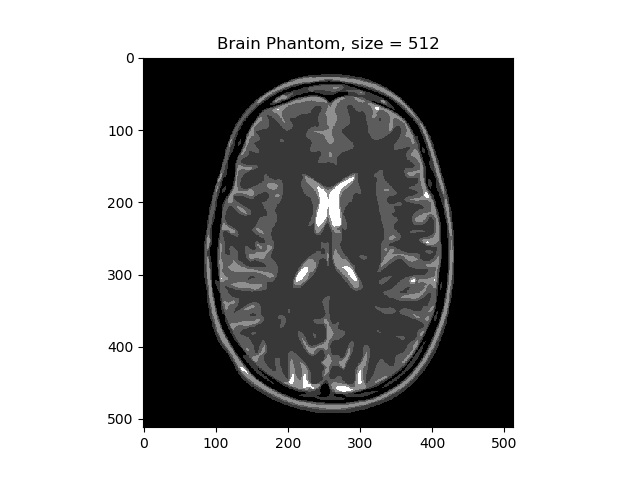

In [1]:
#DISPLAY BRAIN PHANTOM
%matplotlib inline

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys

from skimage import data, img_as_float, io, filters
from skimage.measure import compare_ssim as ssim

#get current working dir

cwd = os.getcwd()
dirimg_2d = op.join(cwd,"..","data")
img_size = 512   #256
FOV = 0.2 #field of view parameter in m (ie real FOV = 20 x20 cm^2)
pixelSize = FOV/img_size

#load data file corresponding to the target resolution
filename = "BrainPhantom" + str(img_size) + ".png"
mri_filename = op.join(dirimg_2d, filename)
mri_img = io.imread(mri_filename, as_gray=True)
plt.figure()
plt.title("Brain Phantom, size = "+ str(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

In [2]:
#PARAMETERS AND CONSTRAINTS
from collections import namedtuple

samplingOptions = namedtuple("samplingOptions", "nc ns OS_factor decim tau decay mask iter init Kmax Smax Gmax gamma dTime n_revol n_epi")




#Kmax depends of FOV and image resolution (NS criterion)
#Gmax and Smax : maximum gradient (T/m) and slew rate (T/m/ms)
#tau, decay and mask parametrize the sampling density (mask=1 for circular - isotrope kspace - 0 otherwise)
#iter = number of iterations (gradient descent steps?)
#mask = initialization for SPARKLING (radial in-out, radial center-out, spiral in-out...)
#gamma = gyromagnetic constant (Hz/T)

samplingOptions.nc = 45 #nc is the number of shots in the k-space
samplingOptions.ns = 3073 #ns is the number of gradient samples per shot
samplingOptions.OS_factor = 1 #Oversampling factor = (gradient raster time)/(gradient dwell time)
samplingOptions.decim = 1 # decimation factor 

samplingOptions.Kmax = img_size/(2*FOV) # Max sampling frequency in m^{-1}: same along k_x, k_y
samplingOptions.Gmax = 40e-3            # hardware constraint on Gmax (gradient magnitude) in mT/m
samplingOptions.Smax = 200e-3           # hardware constraint on Smax (slew rate) in mT/m/ms

samplingOptions.gamma = 42.576e3  #gyro-magnetic ratio en kHz/T
samplingOptions.dTime = 0.010     # dwellTime in ms

64


<IPython.core.display.Javascript object>


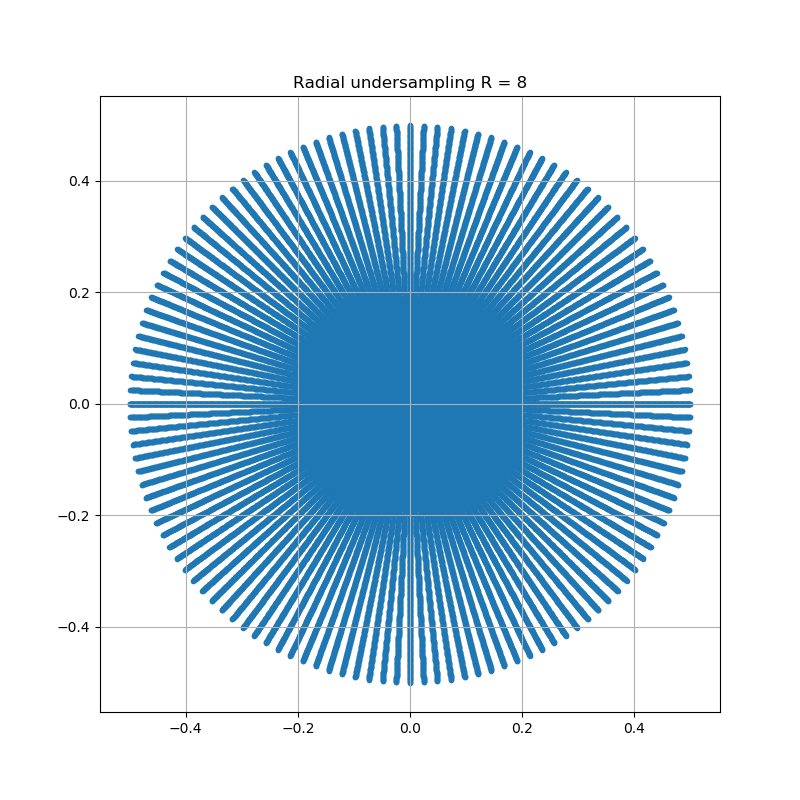

In [16]:
# set up the first shot
rfactor = 8
nb_shots = math.ceil(img_size/rfactor)
print(nb_shots)

# vectorize the nb of shots        
vec_shots = np.arange(0,nb_shots + 1)

# define the regularly spaced samples on a single shot
nsamples = (np.arange(0,2*img_size) - img_size)/(2*img_size)
shot_c = np.array(nsamples, dtype = np.complex_)
shots = np.array([], dtype = np.complex_)    
# acculumate shots after rotating the initial one by the right angular increment        
for k in vec_shots:
    shots = np.append(shots, shot_c * np.exp(2 * np.pi * 1j * k/(2*nb_shots)))

kspace_loc = np.zeros((len(shots),2))
#assign real and imaginary parts of complex-valued k-space trajectories to k-space locations
kspace_loc[:,0] = shots.real
kspace_loc[:,1] = shots.imag
#Plot full initialization
kspace = plt.figure(figsize = (8,8))
#plot shots
plt.scatter(kspace_loc[:,0],kspace_loc[:,1], marker = '.')
plt.title("Radial undersampling R = %d" %rfactor)

axes = plt.gca() 
plt.grid()


In [14]:
data=convert_locations_to_mask(kspace_loc, image.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=image.shape,
                             implementation='cpu')
kspace_obs = fourier_op.op(image.data)

NameError: name 'convert_locations_to_mask' is not defined

In [3]:

#CALCULATED VALUES

alpha = samplingOptions.gamma * samplingOptions.Gmax
beta = samplingOptions.gamma * samplingOptions.Smax

cst_ = 1./(2*np.pi)
alpha_R = alpha/samplingOptions.Kmax * cst_
beta_R = beta/samplingOptions.Kmax * cst_

ns_shot  = 2*math.floor(samplingOptions.ns/2)+1 #odd number of samples for decimation

ns_shot_decim = math.ceil(ns_shot/samplingOptions.decim) #number of shots per decimation step

print("ns_shot_decim = " + str(ns_shot_decim))

Dk0_R = 2*pixelSize/FOV*1/(2*np.pi) #divide by Kmax*2pi

eps = sys.float_info.epsilon
#print("epsilon = " + str(eps))

#Criterium (iii), eq (3.4) C.Lazarus PhD thesis
alpha_R = min( Dk0_R/(samplingOptions.dTime * samplingOptions.OS_factor), alpha_R)

#UNDERSAMPLING FACTOR
#UF = np.power(img_size,2)/(samplingOptions.nc*samplingOptions.ns) #R in C.Lazarus phd 3.3.2
us_fct = img_size**2/(samplingOptions.nc * samplingOptions.ns) #R in C.Lazarus phd 3.3.2

#ACCELERATION RATA
#AF = img_size/samplingOptions.nc
accel_fct = img_size/samplingOptions.nc

print("Undersampling factor = %d " %  us_fct)
print("Acceleration factor = %d" % accel_fct)


ns_shot_decim = 3073
Undersampling factor = 1 
Acceleration factor = 11


In [5]:
print("Initalization for radial In-Out")
        
k_TE = math.ceil(samplingOptions.ns/2) #echo time
k_TE_decim = math.ceil(k_TE/samplingOptions.decim)
        
# set up the first shot
a = np.arange(1,ns_shot_decim+1)
b = (-a/(k_TE_decim-1) + k_TE_decim/(k_TE_decim-1)) * cst_ * (1-eps)
shot_c = np.array(b,dtype = np.complex_) ; 
# vectorize the nb of shots        
vec = np.arange(0,samplingOptions.nc-1+1)
shot = np.array([], dtype = np.complex_)    
        
for k in vec:
    shot = np.append(shot,shot_c * np.exp(2 * np.pi * 1j * k/(2*samplingOptions.nc)))


Initalization for radial In-Out


<IPython.core.display.Javascript object>


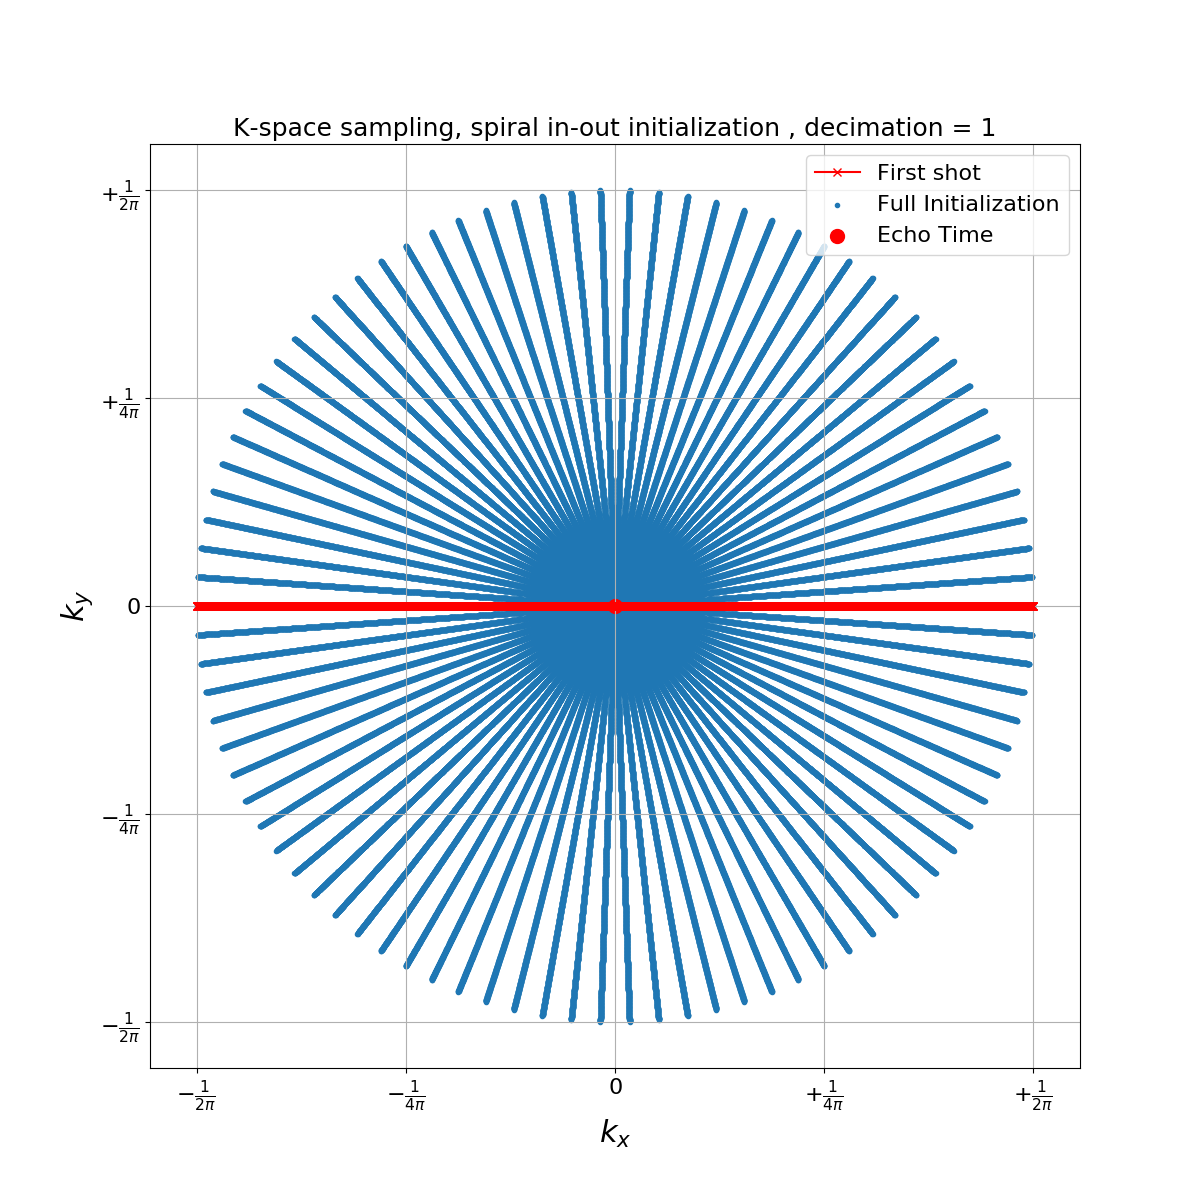

In [6]:
## PLOT SAMPLING SCHEME

k_vec = np.zeros((len(shot),2))
k_vec[:,0] = shot.real
k_vec[:,1] = shot.imag

#Plot full initialization
kspace = plt.figure(figsize = (8,8))

plt.scatter(k_vec[:,0],k_vec[:,1], marker = '.', label = "Full Initialization")

axes = plt.gca() 
plt.grid()

#Display first shot
plt.plot(k_vec[0:ns_shot_decim,0],k_vec[0:ns_shot_decim,1], color='r', marker = 'x'
         , label = "First shot")


#Sample at echo time
plt.scatter(k_vec[k_TE_decim-1,0], k_vec[k_TE_decim-1,1], marker = 'o', color='r', s=100,
            label = "Echo Time")

#Figure layout

unit = 1/4 ; tick = np.arange(-0.5, 0.5 + unit, unit)

label = [r"$-\frac{1}{2\pi}$", r"$-\frac{1}{4\pi}$", r"$0$", r"$+\frac{1}{4\pi}$",  r"$+\frac{1}{2\pi}$"]

plt.xticks(tick/np.pi,labels = label, fontsize = 16) ; plt.yticks(tick/np.pi,labels = label, fontsize = 16)

plt.xlabel(r"$k_x$", fontsize = 22) ; plt.ylabel(r"$k_y$", fontsize = 22)

plt.title("K-space sampling, spiral in-out initialization , decimation = " 
          + str(samplingOptions.decim),fontsize = 18)

plt.legend(fontsize = 16)

plt.show()


In [12]:
#from pynfft.nfft import NFFT
import scipy.misc
import matplotlib.pyplot 
from pynufft import NUFFT_cpu
from skimage.measure import compare_ssim as ssim

NufftObj = NUFFT_cpu()
Nd = (img_size, img_size)  # image size
print('setting image dimension Nd...', Nd)
Kd = (img_size, img_size)  # k-space size
print('setting spectrum dimension Kd...', Kd)
Jd = (6, 6)  # interpolation size
print('setting interpolation size Jd...', Jd)

NufftObj.plan(k_vec*2*np.pi, Nd, Kd, Jd)

mri_img = mri_img*1.0/np.max(mri_img) #image normalization

recons = plt.figure(figsize=(7,7))
kspace_data = NufftObj.forward(mri_img)
print('setting non-uniform data')
print('y is an (M,) list',type(kspace_data), kspace_data.shape)

#image0 = NufftObj.solve(y, solver='cg',maxiter=50)
img_rec0 = NufftObj.solve(kspace_data, solver='cg',maxiter=1e2)
#SSIM
ssim_rec0 = ssim(np.abs(mri_img), np.abs(img_rec0),data_range=mri_img.max() - img_rec0.min())
ssim_rec0 = float(round(abs(ssim_rec0),3))

plt.title('Restored image (cg) : SSIM = ' + str(ssim_rec0))
plt.imshow(img_rec0.real, cmap=matplotlib.cm.gray, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1))


ModuleNotFoundError: No module named 'pynufft'